# Hydrogen depassivation lithography

In [1]:
using LinearAlgebra
using SparseArrays
using DifferentialEquations

In [2]:
# Silicon hydrogen NN interaction. # a
C_1 = 1;
U_Si_H(x) = C_1/x;
d_U_Si_H(x) = -C_1/x^2;

# Hopping between silicon atom and the hydrogen atom. # b
C_2 = 1;
Xi = 1;
t_Si_H(x) = C_2*exp(-x/Xi);
d_t_Si_H(x) = (-C_2/Xi)*exp(-x/Xi);

# Hopping between the STM tip and the hydrogen atom. # c
C_3 = 1;
x_0 = 1;
t_STM_H(x) = C_3*exp(-(x_0-x)/Xi);
d_t_STM_H(x) = (C_3/Xi)*exp(-(x_0-x)/Xi);

In [3]:
Nx = 1
Ny_max = 2

U11 = 1 # nearest neighbor potential in first layer
U22 = 1 # nearest neighbor potential term in 2nd layer
H_U_Si_H = 1 # nearest neighbor potential betweeen hydrogen and silicon atom

t11 = 1 # nearest neighbor hopping in first layer
t22 = 1 # nearest nighbor hopping in 2nd layer

t_si = 1 # nearest neighor hopping between silicon and hydrogen atom
t_b1 = 1 # loss/gain at boundary 1
t_b2 = 1 # loss/gain at boundary 2
t_b3 = 1 # loss/gain at boundary 3
t_b4 = 1; # loss/gain at boundary 4
t_stm = 1; # hopping between the STM tip and the hydrogen atom.

# Mass of an electron.
m_e = 9.11*10^(-31);

In [4]:
#= The following is the potential in which the hydrogen experiences from
the bulk and the surrounding silicon atoms. For now, we will approximate
it as a harmonic potential. =#
k = 1;
# x_0 is defined above.
V(x) = 0.5*k*(x-x_0/2)^2;

In [5]:
#=
In the following lines, specify the position
of the silicon atom and the hydrogen atom in the lattice that we are interested in.
=#

Si_position = 6;
H_position = 13;

In [6]:
it=Iterators.product(ntuple(_ -> 0:1, 1+Nx*Ny_max*6)...);
p=collect(it); # possible states with non conserving particle number

In [7]:
# Generating a matrix with zeros.
H = zeros(2^(1+Nx*Ny_max*6),2^(1+Nx*Ny_max*6)); # 6 nearest neighbours.
size(H);

In [8]:
#= The derivative of the Hamiltonian with respect to x. =#
dH_dx = zeros(2^(1+Nx*Ny_max*6),2^(1+Nx*Ny_max*6));

In [9]:
#= List of bonds for Nx = 1 and Ny = 2 for reference.=#
bonds = [
        # first layer.
        [1,2],[2,3],[3,4],[7,8],[8,9],[9,10],
        # second layer.
        [5,6],[11,12],
        # first to second layer.
        [2,5],[4,6],[8,11],[10,12],
        # second to third layer.
        [8,5],[10,6]
        ];

## Layers
The following loops create arrays for nearest neighbors interactions
and nearest neighbors potentials for layers one and two .

In [10]:
layer_1 = [];
for Ny=1:Ny_max
    for k=6*(Nx)*(Ny-1)+1:6*(Nx)*(Ny-1)+4*Nx-1
        push!(layer_1,[k,k+1])
    end
end
layer_1

6-element Vector{Any}:
 [1, 2]
 [2, 3]
 [3, 4]
 [7, 8]
 [8, 9]
 [9, 10]

In [11]:
layer_2 = [];
for Ny=1:Ny_max
    for k=6*Nx*(Ny-1)+4*Nx+1:2:6*Nx*(Ny-1)+4*Nx+2*Nx-1
        push!(layer_2,[k,k+1])
    end
end
layer_2

2-element Vector{Any}:
 [5, 6]
 [11, 12]

In [12]:
layer_1_2 = [];
for Ny=1:Ny_max
    for n=2:2:4*Nx
        push!(layer_1_2,[Nx*6*(Ny-1)+n,Nx*6*(Ny-1)+4*Nx+Int(n/2)])
    end
end
layer_1_2

4-element Vector{Any}:
 [2, 5]
 [4, 6]
 [8, 11]
 [10, 12]

In [13]:
layer_2_3 = [];
for Ny=2:Ny_max
    for n1=2:2:4*Nx
        push!(layer_2_3,[Nx*6*(Ny-1)+n1,Nx*6*(Ny-2)+4*Nx+Int(n1/2)])
    end
end
layer_2_3

2-element Vector{Any}:
 [8, 5]
 [10, 6]

In [14]:
#= The following concatenates all the ordered pairs. =#
bonds = vcat(layer_1,layer_2,layer_1_2,layer_2_3);

In [15]:
length(p[7])

13

## NN interaction and NN hopping between Silicon layers

In [16]:
# Imagine I'm given a list bonds = [[1,2],[2,3],etc]

for n=1:2^(1+Nx*Ny_max*6) # Loop over basis states

    for j=1:length(bonds)
        
        site1=bonds[j][1] # First number in the pair.
        site2=bonds[j][2] # Second number in the pair.
        
        #=
        Assuming NN interaction between any two layers are same (U11).
        NN interaction term has no Hermitian conjugate.
        If both p[n][site] and p[n][site2] are occupied, then
        the potential U11 will be added to the Hamiltonian. 
        =#
        
        H[n,n] += U11 * p[n][site1] * p[n][site2] # NN Interaction term
        
        
        #= NN hopping has Hermitian conjugate =#
        if p[n][site1] == 1 && p[n][site2]==0 # NN hopping
            q=collect(p[n]) # collect makes p[n] a vector.
            q[site1]=0
            q[site2]=1
            
            phase1=(-1)^(sum(p[n][site1:6*Nx*Ny_max+1]))
            phase2=1
            
            if site2 < 6*Nx*Ny_max+1 
                phase2=(-1)^(sum(p[n][site2:6*Nx*Ny_max+1]))
            end
            
            for n1=1:2^(6*Nx*Ny_max+1)
                if collect(p[n1]) == q
                    H[n,n1]+=t22*phase1*phase2
                    H[n1,n]+=t22*phase1*phase2 # hermitian conjugate
                end
            end
        end
    end
end

### Creating a list of the first and the second boundary

In [17]:
first_bd = [];
second_bd = [];
for Ny=1:Ny_max
    if Ny == 1 # First boundary
        
        for k=6*(Nx)*(Ny-1)+1:6*(Nx)*(Ny-1)+4*Nx
            push!(first_bd,k)
        end
        
    elseif Ny == Ny_max # second boundary.
        
        for k=6*(Nx)*(Ny-1)+4*Nx+1:2:6*(Nx)*(Ny-1)+4*Nx+2*Nx-1
            push!(second_bd,k)
            push!(second_bd,k+1)
        end   
    end
end
first_bd;

In [18]:
second_bd;

### Creating a list of the third and the fourth boundary

In [19]:
third_bd = [];
fourth_bd = [];
for Ny=1:Ny_max
    k=1+Nx*6*(Ny-1)
    push!(third_bd,k)
    k=4*Nx+Nx*6*(Ny-1)
    push!(fourth_bd,k)
    #println(k)  
end
third_bd;

In [20]:
fourth_bd;

### Gain and loss of fermions at the four boundaries

In [21]:
for n=1:2^(Nx*Ny_max*6+1)
    
    # first boundary.
    for j=1:length(first_bd)
        
        site=first_bd[j]
    
        # gain
        if p[n][site]==1  # electron is there. # 1 if gain
            q=collect(p[n])  
            q[site]=0 # electron is lost. # 0 if gain 1 if loss

        # loss    
        elseif p[n][site] == 0 # electron is not there. # 0 if loss
            q=collect(p[n])
            q[site]=1 # electron is gained. # 0 if gain 1 if loss
        end                
          
        #= The phase is calculated below. =#
        #phase1=(-1)^(sum(p[n][k:Nx*Ny_max*6]))
        phase2=1
            
        if site<Nx*Ny_max*6
            phase2=(-1)^(sum(p[n][site:6*Nx*Ny_max+1]))
        end
            
        for n1=1:2^(1+Nx*Ny_max*6)
            if collect(p[n1])==q                
                H[n,n1]+=t_b1*phase2
            end
        end                
    end
            
    # second boundary.
    for j=1:length(second_bd) 
        
        site = second_bd[j]
        
        # loss
        if p[n][site]==1 # electron is there.
            q=collect(p[n])
            q[site]=0 # electron is lost.
                    
        # gain   
        elseif p[n][site]==0 # electron is not there.
            q=collect(p[n])
            q[site]=1 # electron is gained.
            
        end    
        phase2=1
        if site<6*Nx*Ny_max+1
            phase2=(-1)^(sum(p[n][site:6*Nx*Ny_max+1]))
        end
            
            
        for n1=1:2^(6*Nx*Ny_max+1)
            if collect(p[n1])==q
                H[n,n1]+=t_b2*phase2
            end
        end
    end
    
    # third boundary.
    for j=1:length(third_bd) 
        
        site = third_bd[j]
        
        # loss
        if p[n][site]==1 # electron is there.
            q=collect(p[n])
            q[site]=0 # electron is lost.
                    
        # gain   
        elseif p[n][site]==0 # electron is not there.
            q=collect(p[n])
            q[site]=1 # electron is gained.
            
        end  
        
        phase2=1
        if site<6*Nx*Ny_max+1
            phase2=(-1)^(sum(p[n][site:6*Nx*Ny_max+1]))
        end
            
            
        for n1=1:2^(6*Nx*Ny_max+1)
            if collect(p[n1])==q
                H[n,n1]+=t_b3*phase2
            end
        end
    end
    
    # fourth boundary.
    for j=1:length(fourth_bd) 
        
        site = fourth_bd[j]
        
        # loss
        if p[n][site]==1 # electron is there.
            q=collect(p[n])
            q[site]=0 # electron is lost.
                    
        # gain   
        elseif p[n][site]==0 # electron is not there.
            q=collect(p[n])
            q[site]=1 # electron is gained.
            
        end  
        
        phase2=1
        if site<6*Nx*Ny_max+1
            phase2=(-1)^(sum(p[n][site:6*Nx*Ny_max+1]))
        end
            
            
        for n1=1:2^(6*Nx*Ny_max+1)
            if collect(p[n1])==q
                H[n,n1]+=t_b4*phase2
            end
        end
    end    
end     

## Nearest neighbour hopping between the silicon and hydrogen atom

In [22]:
#=
The position of the silicon and the hydrogen attached to it is
specified at the top.
=#

for n = 1:2^(1+Nx*Ny_max*6) # Iterating over all basis states.
    
    #=  
    
    p[n][Si_position] = 1 means there is an electron in the Si atom.
    p[n][H_position] = 0 means there is no electron in the H atom.
    
    =#
    if p[n][H_position]==1 && p[n][Si_position]==0
        
        #println([n,H_position],[n,Si_position])
        
        q=p[n]
        q=collect(p[n])
        
        q[H_position]=0 # The electron in the Si is lost.
        q[Si_position]=1 # An electron in the H is gained.
        
        phase1=(-1)^(sum(p[n][H_position:1+Nx*Ny_max*6]))
        phase2=1
        
        if H_position < Nx*Ny_max*6
            
            phase2=(-1)^(sum(p[n][Si_position:6*Nx*Ny_max+1]))
            
        end
        
        for n1=1:2^(Nx*Ny_max*6)
            
            if collect(p[n1])==q
                # The Hamiltonian.
                H[n,n1] += t_si*phase1*phase2
                H[n1,n] += t_si*phase1*phase2
                
                # Derivative of the Hamiltonian.
                #dH_dx[n,n1] += d_t_Si_H(x)*phase1*phase2
                #dH_dx[n1,n] += d_t_Si_H(x)*phase1*phase2
                #dH_dx[n,n1] *=  "b"
                #dH_dx[n,n1] *=  "b"
            end
            
        end
    end    
end

## NN interaction between the Silicon atom and the Hydrogen atom

In [23]:
#=
The position of the silicon and the hydrogen attached to it is
specified at the top.
=#

for n = 1:2^(1+Nx*Ny_max*6) # Iterating over all basis states.
    
    #=  
    
    p[n][Si_position] = 1 means there is an electron in the Si atom.
    p[n][H_position] = 0 means there is no electron in the H atom.
    
    =#
    if p[n][H_position]==1 && p[n][Si_position]==1
        
        H[n,n] += H_U_Si_H
        #dH[n,n] *= "a"
    end    
end

### Electron loss and gain with the STM tip

In [24]:
#=
Exchange of electrons between the STM tip and the hydrogen atom.
This is a non-Hermitian term in the Hamiltonian. The position of
the hydrogen is specified at the top.
=#


for n = 1:2^(1+Nx*Ny_max*6) # Iterating over all basis states.
    
    # gain
    if p[n][H_position]==1  # electron is there.
        
        q=collect(p[n])  
        q[H_position]=0 # electron is lost.

    # loss    
    elseif p[n][H_position] == 0 # electron is not there.
        
        q=collect(p[n])
        q[H_position]=1 # electron is gained.
        
    end  
        
    for n1=1:2^(Nx*Ny_max*6)
            
        if collect(p[n1])==q
            H[n,n1] += t_stm
            #dH_dx[n,n1] *= "c"
        end
    
    end
    
end    

In [ ]:
H;

In [ ]:
H_tot(x) = H(x)+V(x)+p^2/(2*m_e);

## Construction of derivative of the Hamiltonian

## Equation of motion for $x$

In [115]:
#= 
    The following function solves a set of two cpupled first order ODE using Runge Kutta method
    of order four. Set of Coupled ODE : dy/dt = dydt(t,y,z), dz/dt = dzdt(t,y,z).   
=#

function RK4(t,x,p,dt)

    k1 = dt*dxdt(t,x,p)
    h1 = dt*dpdt(t,x,p)
    k2 = dt*dxdt(t+dt/2, x+k1/2, p+h1/2)
    h2 = dt*dpdt(t+dt/2, x+k1/2, p+h1/2)
    k3 = dt*dxdt(t+dt/2, x+k2/2, p+h2/2)
    h3 = dt*dpdt(t+dt/2, x+k2/2, p+h2/2)
    k4 = dt*dxdt(t+dt, x+k3, p+h3)
    h4 = dt*dpdt(t+dt, x+k3, p+h3)

    x = x + (k1+2*k2+2*k3+k4)/6
    p = p + (h1+2*h2+2*h3+h4)/6
    t = t + dt
    return t,x,p
end;

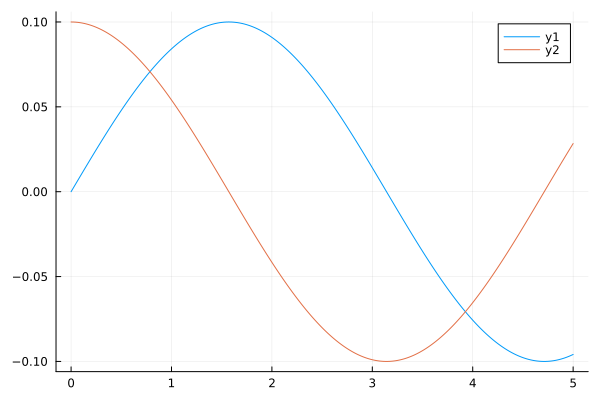

In [118]:
#= Initial conditions. =#
t_i = 0.0
x_i = 0.0
p_i = 0.1
#= List to store the t,y and z values. =#
ts = [t_i]
xs = [x_i]
ps = [p_i]
# Time steps. =#
dt = 1.e-3
# Final time. #
t_end = 5;
# The coupled ODEs. =#
dydt(t,x,p) = p/m;
dzdt(t,x,p) = -k*(x-x_0/2)-(Psi(t))*dH_dx(Nx,Ny_max,x)*(Psi(t)');

#= Initializing the parameters. =#
t = t_i
x = x_i
p = p_i
#= The wavefunction is started with a matrix of random numbers.=#
psi = rand(Float64,(1,2^(1+Nx*Ny_max*6)));
#= The wavefunction is normalized. =#
Psi_i = psi/norm(psi);

while t<t_end

    #= Runge Kutta algorithm of order four. =#
    k1 = dt*dxdt(t,x,p)
    h1 = dt*dpdt(t,x,p)
    k2 = dt*dxdt(t+dt/2, x+k1/2, p+h1/2)
    h2 = dt*dpdt(t+dt/2, x+k1/2, p+h1/2)
    k3 = dt*dxdt(t+dt/2, x+k2/2, p+h2/2)
    h3 = dt*dpdt(t+dt/2, x+k2/2, p+h2/2)
    k4 = dt*dxdt(t+dt, x+k3, p+h3)
    h4 = dt*dpdt(t+dt, x+k3, p+h3)

    x = x + (k1+2*k2+2*k3+k4)/6
    p = p + (h1+2*h2+2*h3+h4)/6
    t = t + dt


    push!(ts,t)
    push!(xs,x)
    push!(ps,p)

    #= The wavefunction at time t+dt. =#
    Psi = exp(-1im*H(x)*dt/hbar)*Psi
end
using Plots
plot(ts,xs)
plot!(ts,ps)

## Equation of motion for $p$

## Equation of motion for $|\psi>$